## Introduction
In this notebook I will create and train the classifier on the chest x-ray dataset to classify whether an image shows signs of pneumonia or not

## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for all kinds of stuff :)
* matplotlib for visualizing some images



In [14]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

First I create the dataset.
I can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return a dataset object with access to all files within the directory and the directory name as class label. <br />
I only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as I only have to load my previously stored numpy files (created on my Kaggle kernel).
Additionally, I need to define a list of file extensions (just "npy" in our case).

Finally I can pass a transformation sequence for Data Augmentation and Normalization.

I use:

* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [15]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [16]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])


val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])




Finally, I create the train and val dataset and the corresponding data loaders.

You can adapt **batch size** and **num_workers** according to your hardware ressources.

In [17]:
train_dataset = torchvision.datasets.DatasetFolder(
    "./Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "./Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)


Let's inspect some augmented train images

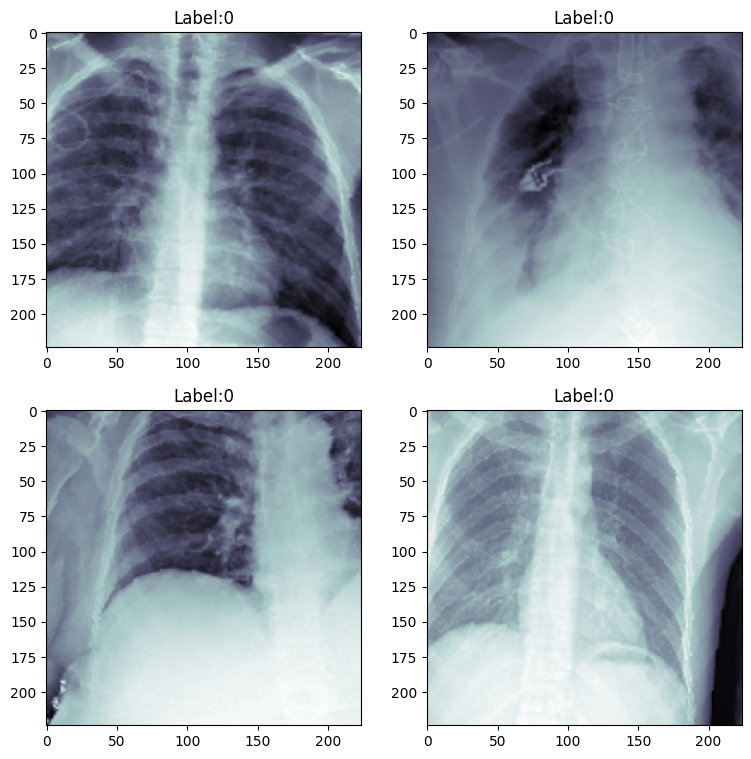

In [18]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


In [19]:
batch_size = 128#TODO
num_workers = 8 #TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing :)

In this example, I will use weighted Loss.
And feel free to play around with a Oversampling or Doing nothing. (Oversampling didn't give me good results)

In [7]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

In [8]:
18593/5407

3.4386905862770485

## Model Creation in pytorch lightning

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, I can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, I define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, I can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Now it is time to create the model** - I will use the **ResNet50 network architecture**.

As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. <br />
However, our X-Ray image data has only one channel.
Thus I need to change the in_channel parameter from 3 to 1.

Additionally, I will change the last fully connected layer to have only one output as I have a binary class label.

### Optimizer and Loss
I use the **Adam** Optimizer with a learning rate of 0.0001 and the **BinaryCrossEntropy** Loss function.<br />
(In fact I use **BCEWithLogitsLoss** which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy).


In [26]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet50()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet50) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        return [self.optimizer]



In [27]:
model = PneumoniaModel()  # Instanciate the model

I create a checkpoint callback which only stores the  best model based on the validation accuracy.

In [28]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=1,
    mode='max',
    verbose=True)

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [29]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"),
                     callbacks=[checkpoint_callback], max_epochs=30,enable_progress_bar=False)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 23.5 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.015    Total estimated model params size (MB)
Epoch 0, global step 188: 'Val Acc' reached 0.27381 (best 0.27381), saving model to './logs/lightning_logs/version_0/checkpoints/epoch=0-step=188.ckpt' as top 1
Epoch 1, global step 376: 'Val Acc' reached 0.51814 (best 0.51814), saving model to './logs/lightning_logs/version_0/checkpoints/epoch=1-step=376.ckpt' as top 1
Epoch 2, global step 564: 'Val Acc' reached 0.60099 (best 0.60099), saving model to './logs/lightning_logs/version_0/checkpoints/epoch=2-step=564.c

## Evaluation

Let's evaluate our model!
At first, I load the latest checkpoint and send the model to the GPU, if possible.

In [31]:
ls -la ./logs/lightning_logs/version_0/checkpoints/

total 275846
drwxr-xr-x 2 root root         1 Aug 22 18:02  ./
drwxr-xr-x 3 root root         3 Aug 22 17:46  ../
-rw-r--r-- 1 root root 282465337 Aug 22 18:02 'epoch=29-step=5640.ckpt'


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("./logs/lightning_logs/version_0/checkpoints/epoch=29-step=5640.ckpt")
model.eval()
model.to(device);

Compute prediction on the complete validation set and store predictions and labels

In [33]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


**Compute metrics:**

I can see that the overall result is already decent with our simple model. .<br />
There are a few false negatives because I handled data imbalance using a weighted loss. So my model is able to detect the maximum number of positive cases.<br />
However, the false positive cases are relatively high (that's why the precision is not as good as the recall).


In [36]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.5)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.745529055595398
Val Precision: 0.46554771065711975
Val Recall: 0.871074378490448
Confusion Matrix:
 tensor([[1474,  605],
        [  78,  527]])
Confusion Matrix 2:
 tensor([[1474,  605],
        [  78,  527]])
